## Import Modules

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

## Read Data

In [2]:
data = pd.read_table('training-data-small.txt',header=None,names=['Class', 'Features'])
# data = pd.read_table('test-data-small.txt',header=None)
# data = pd.read_table('training-data-large.txt',header=None)

## Preprocessing

In [3]:
F_counter= Counter([f for f_list in data.Features.apply(lambda x :x.split(',')) for f in f_list ])
X_counter= Counter([f for f_list in data.Features.apply(lambda x :x.split(',')) for f in f_list if f.startswith('X')])
Y_counter= Counter([f for f_list in data.Features.apply(lambda x :x.split(',')) for f in f_list if f.startswith('Y')])
Z_counter= Counter([f for f_list in data.Features.apply(lambda x :x.split(',')) for f in f_list if f.startswith('Z')])

# F_counter = Counter({f for chunk in pd.read_table('training-data-large.txt',header=None,chunksize=10000,names=['Class','Feat']) 
#                                                  for f_list in chunk.Feat.apply(lambda x : x.split(',')) 
#                                                  for f in f_list})

print ('Number of Unique_features : {}'.format(len(F_counter.keys())))
print ('Number of X_features : {}'.format(len(X_counter.keys())))
print ('Number of Y_features : {}'.format(len(Y_counter.keys())))
print ('Number of Z_features : {}'.format(len(Z_counter.keys())))

Number of Unique_features : 125
Number of X_features : 50
Number of Y_features : 50
Number of Z_features : 25


In [4]:
feat2int = {feat : idx for idx , feat in enumerate(sorted(F_counter.keys()),1)}
int2feat = {idx : feat for idx , feat in enumerate(sorted(F_counter.keys()),1)}
feat2int['PAD'] = 0
int2feat[0]='PAD'

vocab_size = len(int2feat)

In [5]:
def start_with(feature_list,start_ch):
    count = 0
    for feature in feature_list:
        if feature.startswith(start_ch):
            count = count +1
    return count

In [6]:
def one_hot(f_list, word_num, start_ch = None):
    one_hot = np.zeros([word_num])
    for f in f_list:
        if start_ch == None:
            one_hot[f] = 1
        elif f.startswith(start_ch):            
            one_hot[feat2int.get(f)] = 1
    return one_hot.astype(int)

In [7]:
data['Encoded_Feature'] = data.Features.apply(lambda x : [feat2int.get(feat) for feat in  x.split(',')])
data['Encoded_OneHot'] = data.Encoded_Feature.apply(lambda x : one_hot(x, len(F_counter)+1))
data['X_enc'] = data.Features.apply(lambda x : one_hot(x.split(','), vocab_size, start_ch='X'))
data['Y_enc'] = data.Features.apply(lambda x : one_hot(x.split(','), vocab_size, start_ch='Y'))
data['Z_enc'] = data.Features.apply(lambda x : one_hot(x.split(','), vocab_size, start_ch='Z'))
data['X_start'] = data.Features.apply(lambda x : start_with(x,'X'))
data['Y_start'] = data.Features.apply(lambda x : start_with(x,'Y'))
data['Z_start'] = data.Features.apply(lambda x : start_with(x,'Z'))
data['Feature_count'] = data.Features.apply(lambda x : len(x.split(',')))
data.head(1)

,Class,Features,Encoded_Feature,Encoded_OneHot,X_enc,Y_enc,Z_enc,X_start,Y_start,Z_start,Feature_count
0,0,"X773579,Y2640,Y2072,Z4,Z15","[48, 79, 72, 122, 104]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,2,2,5


In [8]:
enc = np.array(data.Encoded_OneHot.tolist(),dtype=float)
enc_X = np.array(data.X_enc.tolist(),dtype=float)
enc_Y= np.array(data.Y_enc.tolist(),dtype=float)
enc_Z = np.array(data.Z_enc.tolist(),dtype=float)
y = data.Class.values.reshape([-1,1]).astype(float)

enc, enc_test, \
enc_X, enc_X_test,\
enc_Y, enc_Y_test,\
enc_Z, enc_Z_test, \
y , y_test = train_test_split(enc ,enc_X,enc_Y,enc_Z,y,train_size = 0.66)

print('Shape of onehot: {}' .format(enc.shape))
print('Shape of x_onehot: {}' .format(enc_X.shape))
print('Shape of y_onehot: {}' .format(enc_Y.shape))
print('Shape of z_onehot: {}' .format(enc_Z.shape))
print('Shape of y: {}' .format(y.shape))

Shape of onehot: (6600, 126)
Shape of x_onehot: (6600, 126)
Shape of y_onehot: (6600, 126)
Shape of z_onehot: (6600, 126)
Shape of y: (6600, 1)


## Explore

The number of class 0 : 6410
The number of class 1 : 3590
1/(0+1) = 0.359 %


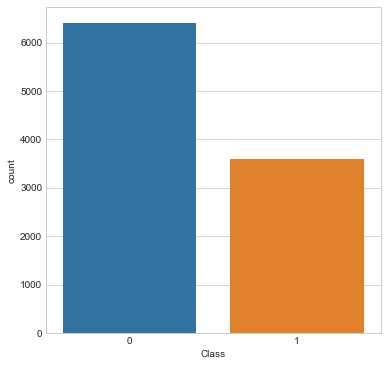

In [9]:
plt.figure(figsize = (6,6))
sns.countplot(x=data.Class)
print("The number of class 0 : {}".format(sum(data.Class==0)))
print("The number of class 1 : {}".format(sum(data.Class==1)))
print("1/(0+1) = {} %".format( sum(data.Class==1) / (sum(data.Class==1)+sum(data.Class==0))))

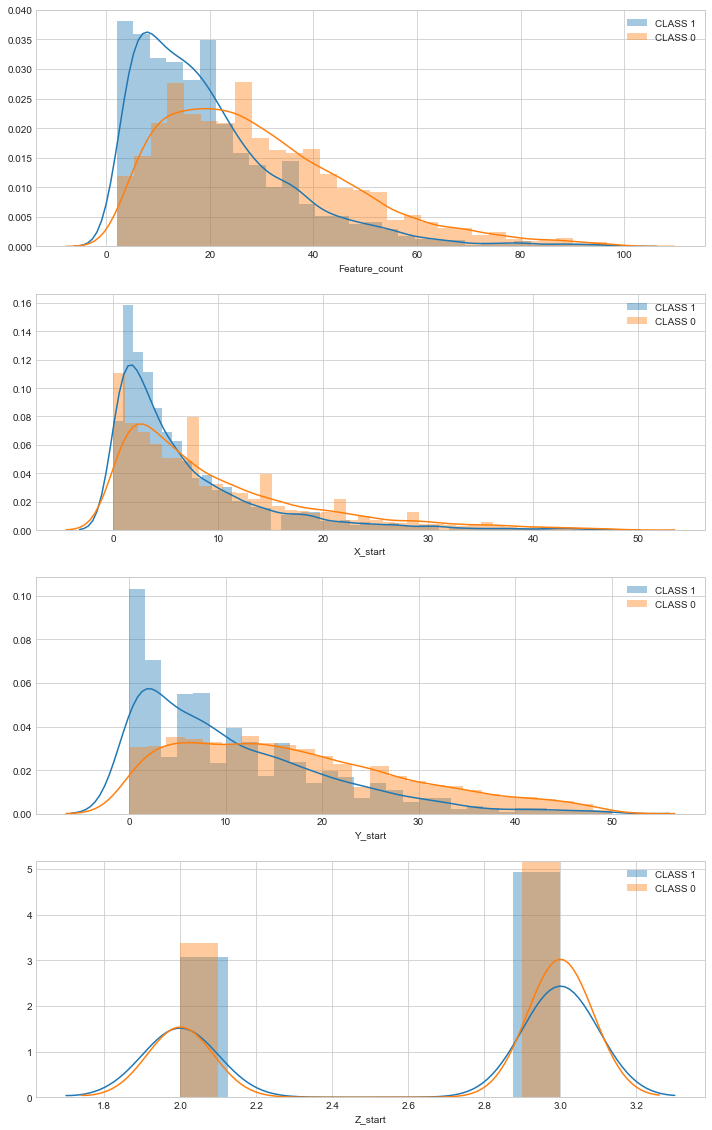

In [10]:
fig , ax = plt.subplots(4,1,figsize=(12,5*4))
ax_ = ax.flatten()

sns.distplot(data.Feature_count[data.Class==1],bins=30,label="CLASS 1", ax=ax_[0])
sns.distplot(data.Feature_count[data.Class==0],bins=30,label="CLASS 0", ax=ax_[0])
ax_[0].legend()

sns.distplot(data.X_start[data.Class==1],label='CLASS 1', ax= ax_[1])
sns.distplot(data.X_start[data.Class==0],label='CLASS 0', ax= ax_[1])
ax_[1].legend()

sns.distplot(data.Y_start[data.Class==1],label='CLASS 1', ax= ax_[2])
sns.distplot(data.Y_start[data.Class==0],label='CLASS 0', ax= ax_[2])
ax_[2].legend()

sns.distplot(data.Z_start[data.Class==1],label='CLASS 1', ax= ax_[3])
sns.distplot(data.Z_start[data.Class==0],label='CLASS 0', ax= ax_[3])
ax_[3].legend()

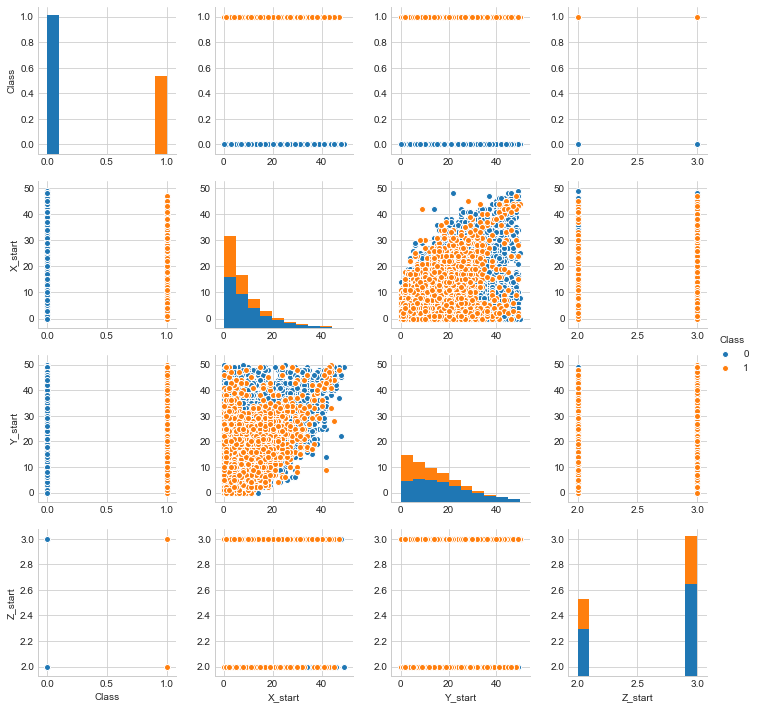

In [11]:
sns.pairplot(data[['Class','X_start','Y_start','Z_start']],hue='Class')

### there is no duplicate feature

In [13]:
(data.Features.apply(lambda x : len(set(x.split(',')))) == data.Feature_count).all()

True

## Make Preprocessing function for batch training

### Easy preprocessing

In [9]:
# feature = {f for f_list in data.Features.apply(lambda x:x.split(',')) for f in f_list }
# vectorizer=CountVectorizer()
# vectorizer.fit(feature)
# x = vectorizer.transform(data.Features)

In [10]:
def get_batches(enc, enc_X, enc_Y, enc_Z, y , batch_size = 256):        
    sample_size = len(enc)
    
    for i in range(0,sample_size,batch_size):
        _enc = enc[ i : i+batch_size,:]
        _enc_X = enc_X[ i : i+batch_size,:]
        _enc_Y = enc_Y[ i : i+batch_size,:]
        _enc_Z = enc_Z[ i : i+batch_size,:]
        _y =y[ i : i+batch_size,:]
        yield _enc, _enc_X, _enc_Y, _enc_Z, _y        

In [11]:
def build_layer(inputs, out_num, activation = None, name = None):

    inputs_dim = inputs.shape.as_list()[-1]

    W = tf.get_variable('Weight',
                        shape=[inputs_dim,out_num],
                        dtype=tf.float32,
                        initializer=tf.truncated_normal_initializer())

    b = tf.get_variable('bias',
                        shape=[out_num],
                        dtype=tf.float32,
                        initializer=tf.truncated_normal_initializer())

    if activation is None:
        return tf.add(tf.matmul(inputs,W), b, name=name)

    else:
        return activation(tf.add(tf.matmul(inputs, W), b), name=name)

In [13]:
class Model(object):
    def __init__(self, vocab_size, i_out_num, x_out_num, y_out_num, z_out_num):

        self.vocab_size = vocab_size

        self.i_num = i_out_num
        self.x_num = x_out_num
        self.y_num = y_out_num
        self.z_num = z_out_num

        # Set Placeholder
        self.inputs = tf.placeholder(tf.float32, shape=[None, self.vocab_size])
        self.x_inputs = tf.placeholder(tf.float32, shape=[None, self.vocab_size])
        self.y_inputs = tf.placeholder(tf.float32, shape=[None, self.vocab_size])
        self.z_inputs = tf.placeholder(tf.float32, shape=[None, self.vocab_size])
        self.labels = tf.placeholder(tf.float32, shape=[None,1])
        
        self.is_train = tf.placeholder(tf.bool)        
        self.drop_rate = tf.placeholder(tf.float32)
        self.learning_rate = tf.placeholder(tf.float32)

        with tf.variable_scope('input_layer'):
            self.out_i = build_layer(self.inputs, i_out_num, tf.nn.sigmoid, name='out_i')
            tf.get_variable_scope().reuse_variables()
            tf.summary.histogram('W_input', tf.get_variable('Weight'))
            tf.summary.histogram('b_input', tf.get_variable('bias'))
        
        with tf.variable_scope('x_input_layer'):
            self.out_x = build_layer(self.x_inputs, x_out_num, tf.nn.sigmoid, name='out_x')
            tf.get_variable_scope().reuse_variables()
            tf.summary.histogram('W_x', tf.get_variable('Weight'))
            tf.summary.histogram('b_x', tf.get_variable('bias'))
        
        with tf.variable_scope('y_input_layer'):
            self.out_y = build_layer(self.y_inputs, y_out_num, tf.nn.sigmoid,name='out_y')
            tf.get_variable_scope().reuse_variables()
            tf.summary.histogram('W_y', tf.get_variable('Weight'))
            tf.summary.histogram('b_y', tf.get_variable('bias'))
        
        with tf.variable_scope('z_input_layer'):
            self.out_z = build_layer(self.z_inputs, z_out_num, tf.nn.sigmoid,name='out_z')
            tf.get_variable_scope().reuse_variables()
            tf.summary.histogram('W_z', tf.get_variable('Weight'))
            tf.summary.histogram('b_z', tf.get_variable('bias'))

        with tf.name_scope('concat'):
            self.concat = tf.concat([self.out_i, self.out_x, self.out_y, self.out_z], axis=1, name='concat')
                    
        with tf.name_scope('drop'):
            # Conditionaly return node
            self.drop = tf.cond(self.is_train, 
                                                lambda: tf.layers.dropout(self.concat, rate=self.drop_rate, training=self.is_train, name='drop_train'),
                                                lambda: tf.identity(self.concat,name='drop_infer'))

        with tf.name_scope('out'):
            self.logit = build_layer(self.drop, 1, activation=None, name ='logit')

        with tf.name_scope('loss'):
            self.loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(labels=self.labels,logits=self.logit),name = 'loss')
            tf.summary.scalar('loss',self.loss)

        with tf.name_scope('opt'):
            self.opt = tf.train.AdamOptimizer(learning_rate=self.learning_rate,name='optimizer').minimize(self.loss)
        
        with tf.name_scope('pred'):
            self.predic = tf.equal(tf.cast(tf.round(tf.sigmoid(self.logit)),tf.int32),tf.cast(self.labels,tf.int32), name='prediction')
            self.accuracy = tf.reduce_mean(tf.cast(self.predic,tf.float32), name = 'acc')
        
        with tf.name_scope('infer'):
            self.infer = tf.cast(tf.round(tf.sigmoid(self.logit)),tf.int32,name='inference')
        
        self.merged = tf.summary.merge_all()

    def train(self, sess, feed_dict):        
            _ = sess.run(self.opt,feed_dict = feed_dict)
            return     

## Training Models

In [ ]:
# Using TensorBoard ! 
# Make 9 experiments for model selection

for learning_rate in [0.1,0.01,0.001]:
    for num_layers in [5,10,15]:
        tf.reset_default_graph()
        log_string = 'logs/lr={},rl={}'.format(learning_rate, num_layers)
        writer = tf.summary.FileWriter(log_string)

        with tf.Session() as sess:    
            step = 1
            epoch = 1000            
            layer_units = [num_layers]*4                        
            model = Model(vocab_size,*layer_units)
            sess.run(tf.global_variables_initializer())
            
            print("-"*100)
            print("learning_rate :{} / num_layer : {}".format(learning_rate,num_layers))
            print("-"*100)
            
            for e in range(epoch):
                for batch in get_batches(enc, enc_X, enc_Y, enc_Z, y):
                    step = step + 1

                    # Training Spec
                    feed_dict={model.inputs : batch[0], 
                               model.x_inputs : batch[1],
                               model.y_inputs : batch[2],
                               model.z_inputs : batch[3],
                               model.labels : batch[4],
                               model.is_train : True,
                               model.drop_rate: 0.8,
                               model.learning_rate:learning_rate}

                    model.train(sess,feed_dict)

                    if step % 1000 == 0:
                        feed_dict_train={model.inputs : batch[0], 
                               model.x_inputs : batch[1],
                               model.y_inputs : batch[2],
                               model.z_inputs : batch[3],
                               model.labels : batch[4],
                               model.is_train : False,
                               model.drop_rate: 0,
                               model.learning_rate:learning_rate}

                        feed_dict_test={model.inputs : enc_test, 
                               model.x_inputs : enc_X_test,
                               model.y_inputs : enc_Y_test,
                               model.z_inputs : enc_Z_test,
                               model.labels : y_test,
                               model.is_train : False,
                               model.drop_rate: 0,
                               model.learning_rate:learning_rate}
                        
                        # Summary (TensorBoard)
                        summary = sess.run(model.merged,feed_dict=feed_dict)
                        writer.add_summary(summary, step)

                        training_loss = sess.run(model.loss,feed_dict = feed_dict_train)
                        test_loss , test_acc = sess.run([model.loss, model.accuracy] , feed_dict = feed_dict_test)                
                
                        print("epoch : {} / {} || steps : {}".format(e,epoch,step))                                                
                        print("Training Loss : {} || Test Loss : {}".format(training_loss,test_loss))
                        print("Accuracy : {}".format(test_acc))
                        print()

                    
                    
        writer.close()

## Training model

In [14]:
tf.reset_default_graph()

with tf.Session() as sess:    
    step = 1
    epoch = 500
    vocab_size = 126
    num_layers = 15
    learning_rate = 0.001
    
    layer_units = [num_layers]*4                        
    model = Model(vocab_size,*layer_units)
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())

    print("-"*100)
    print("learning_rate :{} / num_layer : {}".format(learning_rate,num_layers))
    print("-"*100)

    for e in range(epoch):
            
        for batch in get_batches(enc, enc_X, enc_Y, enc_Z, y):
            step = step + 1

            # Training Spec
            feed_dict={model.inputs : batch[0], 
                       model.x_inputs : batch[1],
                       model.y_inputs : batch[2],
                       model.z_inputs : batch[3],
                       model.labels : batch[4],
                       model.is_train : True,
                       model.drop_rate: 0.8,
                       model.learning_rate:learning_rate}

            model.train(sess,feed_dict)
            
            if step % 2000 == 0:
                saver.save(sess,'../log/model_parm')
                
            if step % 500 == 0:
                feed_dict_train={model.inputs : batch[0], 
                       model.x_inputs : batch[1],
                       model.y_inputs : batch[2],
                       model.z_inputs : batch[3],
                       model.labels : batch[4],
                       model.is_train : False,
                       model.drop_rate: 0,
                       model.learning_rate:learning_rate}

                feed_dict_test={model.inputs : enc_test, 
                       model.x_inputs : enc_X_test,
                       model.y_inputs : enc_Y_test,
                       model.z_inputs : enc_Z_test,
                       model.labels : y_test,
                       model.is_train : False,
                       model.drop_rate: 0,
                       model.learning_rate:learning_rate}

                training_loss = sess.run(model.loss,feed_dict = feed_dict_train)
                test_loss , test_acc = sess.run([model.loss, model.accuracy] , feed_dict = feed_dict_test)                

                print("epoch : {} / {} || steps : {}".format(e,epoch,step))                                                
                print("Training Loss : {} || Test Loss : {}".format(training_loss,test_loss))
                print("Accuracy : {}".format(test_acc))
                print()

----------------------------------------------------------------------------------------------------
learning_rate :0.001 / num_layer : 15
----------------------------------------------------------------------------------------------------
epoch : 19 / 500 || steps : 500
Training Loss : 0.6619973182678223 || Test Loss : 0.665492057800293
Accuracy : 0.6673529148101807

epoch : 38 / 500 || steps : 1000
Training Loss : 0.5709121227264404 || Test Loss : 0.5728541016578674
Accuracy : 0.6902941465377808

epoch : 57 / 500 || steps : 1500
Training Loss : 0.5626398324966431 || Test Loss : 0.5580120086669922
Accuracy : 0.6994117498397827

epoch : 76 / 500 || steps : 2000
Training Loss : 0.518495500087738 || Test Loss : 0.5478214621543884
Accuracy : 0.7088235020637512

epoch : 96 / 500 || steps : 2500
Training Loss : 0.5275301933288574 || Test Loss : 0.5377560257911682
Accuracy : 0.716176450252533

epoch : 115 / 500 || steps : 3000
Training Loss : 0.5241575241088867 || Test Loss : 0.5282956957817

## DNN classifier

INFO:tensorflow:Restoring parameters from ../log/model_parm
             precision    recall  f1-score   support

        0.0       0.78      0.87      0.83      2140
        1.0       0.73      0.58      0.65      1260

avg / total       0.76      0.77      0.76      3400



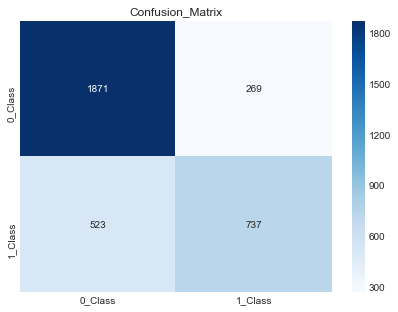

In [15]:
tf.reset_default_graph()  
imported_meta = tf.train.import_meta_graph("../log/model_parm.meta") 

# Plotting Confusion Matrix ( Using Check Point!)
with tf.Session() as sess:
    
    # Restore 
    imported_meta.restore(sess, tf.train.latest_checkpoint('../log/'))
    
    feed_dict_test={model.inputs.name : enc_test, 
                       model.x_inputs.name : enc_X_test,
                       model.y_inputs.name : enc_Y_test,
                       model.z_inputs.name : enc_Z_test,
                       model.labels.name : y_test,
                       model.is_train.name : False,
                       model.drop_rate.name: 0,
                       model.learning_rate.name:learning_rate}
    
    y_pred  = sess.run(model.infer.name,feed_dict=feed_dict_test)
    cf_mtx = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(7,5))
    sns.heatmap(cf_mtx,xticklabels=['0_Class','1_Class'],yticklabels=['0_Class','1_Class'], 
                annot= True , cmap='Blues',fmt='g')
    plt.title('Confusion_Matrix')

    # Report     
    print(classification_report(y_test, y_pred))

## SVM

### Linear kernel

             precision    recall  f1-score   support

        0.0       0.82      0.80      0.81      2195
        1.0       0.65      0.68      0.67      1205

avg / total       0.76      0.76      0.76      3400



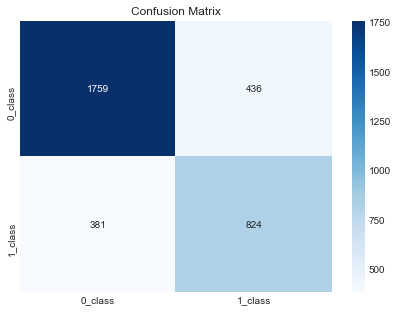

In [16]:
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(enc,y.reshape(-1))
print(classification_report(clf.predict(enc_test),y_test))

plt.figure(figsize=(7,5))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(clf.predict(enc_test),y_test),
            xticklabels=['0_class','1_class'],yticklabels=['0_class','1_class'],cmap='Blues',annot=True,fmt='g')

             precision    recall  f1-score   support

        0.0       0.84      0.83      0.83      2228
        1.0       0.68      0.70      0.69      1172

avg / total       0.79      0.79      0.79      3400



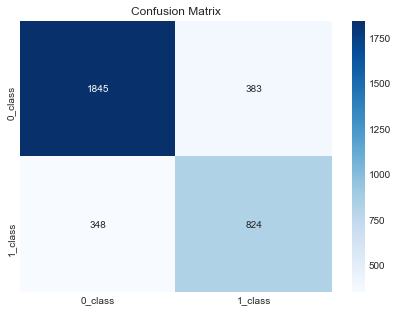

In [55]:
from sklearn import svm
clf = svm.SVC()
clf.fit(enc,y.reshape(-1))
print(classification_report(clf.predict(enc_test),y_test))

plt.figure(figsize=(7,5))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(clf.predict(enc_test),y_test),
            xticklabels=['0_class','1_class'],yticklabels=['0_class','1_class'],cmap='Blues',annot=True,fmt='g')

## Logistic Regression

             precision    recall  f1-score   support

        0.0       0.85      0.82      0.84      2270
        1.0       0.67      0.71      0.69      1130

avg / total       0.79      0.79      0.79      3400



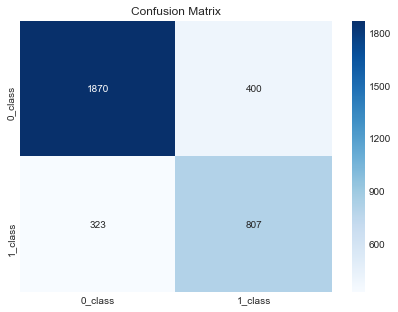

In [50]:
import sklearn.linear_model
clf = sklearn.linear_model.LogisticRegression()
clf.fit(enc,y.reshape(-1))

print(classification_report(clf.predict(enc_test),y_test))

plt.figure(figsize=(7,5))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(clf.predict(enc_test),y_test),
            xticklabels=['0_class','1_class'],yticklabels=['0_class','1_class'],cmap='Blues',annot=True,fmt='g')

## Naive_Bayes Classification

### MultinomialNB

The parameters \theta_y is estimated by a smoothed version of maximum likelihood, i.e. relative frequency counting:

$\hat{\theta}_{yi} = \frac{ N_{yi} + \alpha}{N_y + \alpha n}$

where N_{yi} = \sum_{x \in T} x_i is the number of times feature i appears in a sample of class y in the training set T, and N_{y} = \sum_{i=1}^{|T|} N_{yi} is the total count of all features for class y.

             precision    recall  f1-score   support

        0.0       0.74      0.81      0.77      1986
        1.0       0.69      0.60      0.64      1414

avg / total       0.72      0.72      0.72      3400



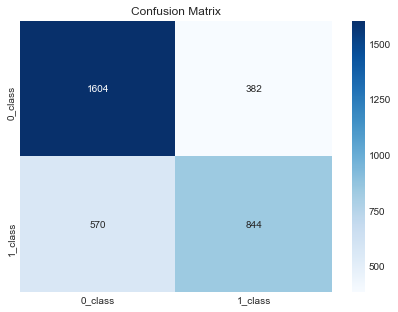

In [10]:
import sklearn.naive_bayes
clf =  sklearn.naive_bayes.MultinomialNB()
clf.fit(enc,y.reshape(-1))

print(classification_report(clf.predict(enc_test),y_test))

plt.figure(figsize=(7,5))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(clf.predict(enc_test),y_test),
            xticklabels=['0_class','1_class'],yticklabels=['0_class','1_class'],cmap='Blues',annot=True,fmt='g')

### BernoulliNB

The decision rule for Bernoulli naive Bayes is based on

$P(x_i \mid y) = P(i \mid y) x_i + (1 - P(i \mid y)) (1 - x_i)$

which differs from multinomial NB’s rule in that it explicitly penalizes the non-occurrence of a feature i that is an indicator for class y, where the multinomial variant would simply ignore a non-occurring feature.

             precision    recall  f1-score   support

        0.0       0.59      0.80      0.68      1611
        1.0       0.73      0.49      0.59      1789

avg / total       0.66      0.64      0.63      3400



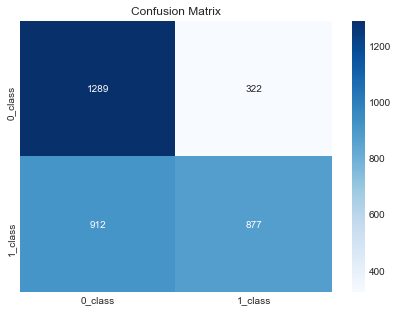

In [11]:
import sklearn.naive_bayes
clf =  sklearn.naive_bayes.BernoulliNB()
clf.fit(enc,y.reshape(-1))

print(classification_report(clf.predict(enc_test),y_test))

plt.figure(figsize=(7,5))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(clf.predict(enc_test),y_test),
            xticklabels=['0_class','1_class'],yticklabels=['0_class','1_class'],cmap='Blues',annot=True,fmt='g')

## Decision Tree Classification

             precision    recall  f1-score   support

        0.0       0.72      0.74      0.73      2154
        1.0       0.53      0.50      0.51      1246

avg / total       0.65      0.65      0.65      3400



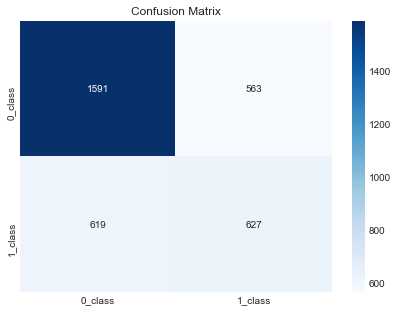

In [51]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(enc,y)

print(classification_report(clf.predict(enc_test),y_test))

plt.figure(figsize=(7,5))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(clf.predict(enc_test),y_test),
            xticklabels=['0_class','1_class'],yticklabels=['0_class','1_class'],cmap='Blues',annot=True,fmt='g')